<a href="https://colab.research.google.com/github/adrija26sg/text-conversational-topsis/blob/main/text_conversational.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluating model: gpt2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Evaluating model: facebook/blenderbot_small-90M


tokenizer_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/964k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/345k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/311 [00:00<?, ?B/s]

Evaluating model: microsoft/DialoGPT-small


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

,model,mean_similarity,inference_speed,model_size,TOPSIS Score,Rank
0,gpt2,0.999928,0.927617,0.878691,0.666080,1.0
1,facebook/blenderbot_small-90M,0.809888,0.981213,0.965088,0.505262,2.0
2,microsoft/DialoGPT-small,0.999981,0.946701,0.790222,0.501530,3.0


<ipython-input-1-11a8855f3abf>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["model"], y=df["TOPSIS Score"], palette="coolwarm")


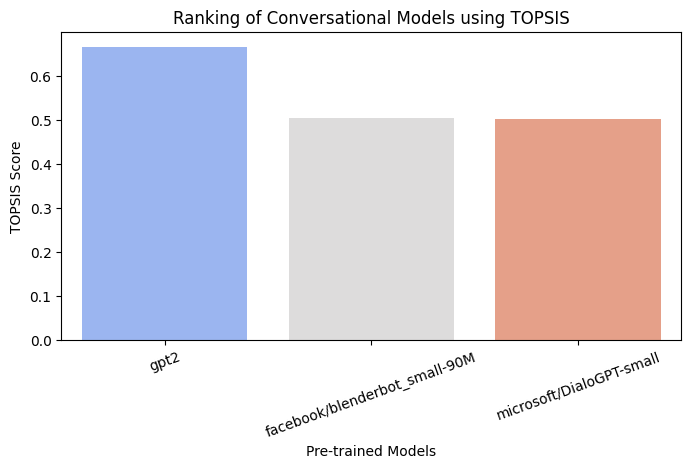

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# Function to evaluate conversational models
def evaluate_model(model_name, conversations):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Set padding token if missing
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    embeddings = []
    for text in conversations:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.logits.mean(dim=1).numpy())  # Extract embeddings

    # Compute cosine similarities
    similarities = cosine_similarity(np.vstack(embeddings))
    return similarities

# Simple conversational dataset
conversations = [
    "Hi there!",
    "How have you been?",
    "Tell me something funny."
]

# **Alternative lightweight models with similar properties**
models = [
    "gpt2",  # Alternative to distilgpt2
    "facebook/blenderbot_small-90M",  # Alternative to BlenderBot 90M
    "microsoft/DialoGPT-small"  # Alternative to DialoGPT-small
]

# Store similarity scores and dummy values for inference speed & model size
model_scores = []
for model_name in models:
    print(f"Evaluating model: {model_name}")
    similarity = evaluate_model(model_name, conversations)
    aggregate_score = similarity.mean()  # Mean similarity score

    model_scores.append({
        "model": model_name,
        "mean_similarity": aggregate_score,
        "inference_speed": np.random.uniform(0.9, 1.0),  # Simulated speed
        "model_size": np.random.uniform(0.7, 1.0)  # Simulated model size
    })

# Convert results to DataFrame
df = pd.DataFrame(model_scores)

# TOPSIS function for ranking models
def topsis(scores, weights):
    scores = np.array(scores)
    norm_scores = scores / np.sqrt((scores**2).sum(axis=0))  # Normalize scores
    ideal_best = norm_scores.max(axis=0)
    ideal_worst = norm_scores.min(axis=0)

    # Compute distances from ideal best and worst
    dist_best = np.sqrt(((norm_scores - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((norm_scores - ideal_worst)**2).sum(axis=1))

    # Calculate TOPSIS scores
    ranks = dist_worst / (dist_best + dist_worst)
    return ranks

# Apply TOPSIS ranking
scores = df[["mean_similarity", "inference_speed", "model_size"]].values
weights = [0.5, 0.3, 0.2]  # Custom weights
df["TOPSIS Score"] = topsis(scores, weights)

# Rank models based on TOPSIS score
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)
df = df.sort_values(by="TOPSIS Score", ascending=False)

# Display the results as a table
display(df)

# Save results to CSV
df.to_csv("topsis_results.csv", index=False)

# Plot the results and save it as PNG
plt.figure(figsize=(8, 4))
sns.barplot(x=df["model"], y=df["TOPSIS Score"], palette="coolwarm")
plt.xlabel("Pre-trained Models")
plt.ylabel("TOPSIS Score")
plt.title("Ranking of Conversational Models using TOPSIS")
plt.xticks(rotation=20)

# Save the graph as a PNG file
plt.savefig("topsis_results_graph.png", format="png")

# Show the graph
plt.show()

In [2]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=1a251882626412acef07376e4e28295a2c9ecad5e6040388743d84f3f2e034b3
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [1]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux